In [4]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from hyperopt.pyll import scope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, train_test_split

In [23]:
df = pd.read_csv('C:/Users/Multiplexon/Desktop/data/2/total_selected_augmented.csv', sep=',')
df.head()


,Transaction Hash_len,Original_len,signature_len,From_len,To_len,sender_len,paymaster_len,Txn Fee,Gas Used,logIndex,actualGasCost,actualGasUsed,nonce,success,Blockno,DateTime_ts
0,32,964,4,20,20,20,20,0.022033,398741,245,2.190000e+16,397164,0.0,1,17066994,1681740540
1,32,868,4,20,20,20,20,0.004362,87702,231,4.280000e+15,86113,1.0,1,17067000,1681740600
2,32,868,4,20,20,20,20,0.003971,87714,273,3.900000e+15,86125,2.0,1,17067009,1681740720
3,32,1188,4,20,20,20,20,0.008673,161702,429,8.650000e+15,161161,3.0,1,17078992,1681887000
4,32,1188,4,20,20,20,20,0.006445,127502,393,6.420000e+15,126973,4.0,1,17079029,1681887420


In [ ]:
features = ['Transaction Hash_len','Original_len','signature_len',
            'From_len','To_len','sender_len','paymaster_len',
            'Txn Fee','logIndex','actualGasCost',
            'actualGasUsed','nonce','success','Blockno','DateTime_ts']

# separate X, y 
X = df.loc[:, features]
y = df['Gas Used']

# 1) Split firstly
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=10, train_size=0.8, shuffle=True
)

print("Before scaling:")
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} "
      f"\nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

# 2) Scale X by MinMaxScaler
scaler_X = MinMaxScaler()
X_train_scaled = pd.DataFrame(
    scaler_X.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler_X.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
# 3) Scale y by MinMaxScaler
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1,1)).ravel()

print("\nAfter scaling:")
print(f"X_train_scaled: {X_train_scaled.shape} \ny_train_scaled: {y_train_scaled.shape} "
      f"\nX_val_scaled: {X_val_scaled.shape}, \ny_val_scaled: {y_val_scaled.shape}")

# 4) checking min/max after scaled
print("\nCheck scaling X_train (min/max):")
print(X_train_scaled.min().round(3))
print(X_train_scaled.max().round(3))

print("\nCheck scaling y_train (min/max):")
print(y_train_scaled.min().round(3), y_train_scaled.max().round(3))

Before scaling:
X_train: (87492, 15) 
y_train: (87492,) 
X_val: (21873, 15), 
y_val: (21873,)

After scaling:
X_train_scaled: (87492, 15) 
y_train_scaled: (87492,) 
X_val_scaled: (21873, 15), 
y_val_scaled: (21873,)

Check scaling X_train (min/max):
Transaction Hash_len    0.0
Original_len            0.0
signature_len           0.0
From_len                0.0
To_len                  0.0
sender_len              0.0
paymaster_len           0.0
Txn Fee                 0.0
logIndex                0.0
actualGasCost           0.0
actualGasUsed           0.0
nonce                   0.0
success                 0.0
Blockno                 0.0
DateTime_ts             0.0
dtype: float64
Transaction Hash_len    0.0
Original_len            1.0
signature_len           0.0
From_len                0.0
To_len                  0.0
sender_len              0.0
paymaster_len           0.0
Txn Fee                 1.0
logIndex                1.0
actualGasCost           1.0
actualGasUsed           1.0
nonce  

In [ ]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
df = pd.read_csv(r'C:/Users/Multiplexon/Desktop/data/2/total_selected_augmented.csv')

features = [
    'Transaction Hash_len', 'Original_len', 'signature_len', 'From_len', 'To_len',
    'sender_len', 'paymaster_len', 'Txn Fee', 'logIndex', 'actualGasCost',
    'actualGasUsed', 'nonce', 'success', 'Blockno', 'DateTime_ts'
]
target = 'Gas Used'

X_raw = df[features].copy()
y_raw = df[target].astype(float).copy()

# Hold-out for Hyperopt
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=SEED
)

# MinMax scale on TRAIN, transform VAL
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_val_s   = y_scaler.transform(y_val.values.reshape(-1,1)).ravel()

# ----- 1) definition of parameters -----
catboost_hyperopt_space = {
    "iterations": scope.int(hp.quniform("iterations", 1000, 50000, 500)),
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-3), np.log(3e-1)),
    "depth": scope.int(hp.quniform("depth", 4, 10, 1)),
    "l2_leaf_reg": hp.loguniform("l2_leaf_reg", np.log(1e-2), np.log(1e2)),
    "min_data_in_leaf": scope.int(hp.quniform("min_data_in_leaf", 1, 2000, 1)),
    "random_strength": hp.uniform("random_strength", 0.0, 2.0),
}

catboost_fixed_params = {
    "eval_metric": "RMSE",
    "random_seed": SEED,
    "task_type": "GPU",
    "devices": "0",
    "logging_level": "Silent",
}

catboost_fit_params = {
    "early_stopping_rounds":100,
    "verbose": False,
    "use_best_model": True,
}

# ----- 2) simplyfize HPOptimiser -----
class HPOptimiser:
    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val   = X_val
        self.y_train = y_train
        self.y_val   = y_val

    def objective(self, hyperparams):
        model_params = {**hyperparams, **catboost_fixed_params}
        model = CatBoostRegressor(**model_params)
        model.fit(self.X_train, self.y_train,
                  eval_set=(self.X_val, self.y_val),
                  **catboost_fit_params)
        pred = model.predict(self.X_val)
        rmse = float(np.sqrt(mean_squared_error(self.y_val, pred)))
        return {'loss': rmse, 'status': STATUS_OK, 'model': model}

    def run(self, space, max_evals=2):
        trials = Trials()
        best = fmin(
            fn=self.objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            rstate=np.random.default_rng(SEED)
        )
        return best, trials

# ====== 3) optimized HYPEROPT on data SCALED ======
print("Bắt đầu tối ưu hóa Hyperopt...")
opt = HPOptimiser(X_train_s, X_val_s, y_train_s, y_val_s)
best_indices, trials = opt.run(catboost_hyperopt_space, max_evals=2) 

opt_catboost_params = space_eval(catboost_hyperopt_space, best_indices)
opt_catboost_params.update(catboost_fixed_params)

print("\n=== TỐI ƯU HOÀN TẤT ===")
print("Best scaled RMSE:", trials.best_trial["result"]["loss"])
print("Các tham số tối ưu (opt_catboost_params):")
print(opt_catboost_params)



N_FOLDS = 10
early_stop_rounds = 100

k_folds = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# ----- 2) run model -----
run_params = dict(opt_catboost_params)
run_params.pop("rsm", None)
mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(k_folds.split(X_raw, y_raw), 1):
    X_tr, X_va = X_raw.iloc[train_idx].copy(), X_raw.iloc[val_idx].copy()
    y_tr = y_raw.iloc[train_idx].astype(float).values.reshape(-1,1)
    y_va = y_raw.iloc[val_idx].astype(float).values.reshape(-1,1)


    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_tr_s = xs.fit_transform(X_tr).astype(np.float32)
    X_va_s = xs.transform(X_va).astype(np.float32)
    y_tr_s = ys.fit_transform(y_tr).ravel().astype(np.float32)
    y_va_s = ys.transform(y_va).ravel().astype(np.float32)

    model = CatBoostRegressor(**run_params)
    model.fit(X_tr_s, y_tr_s,
              eval_set=(X_va_s, y_va_s),
              use_best_model=True,
              early_stopping_rounds=early_stop_rounds,
              verbose=False)

    pred = model.predict(X_va_s).ravel().astype(np.float32)
    mse  = mean_squared_error(y_va_s, pred)
    rmse = float(np.sqrt(mse))
    mae  = mean_absolute_error(y_va_s, pred)
    r2   = r2_score(y_va_s, pred)
    
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f'[Fold {fold:2d}] RMSE: {rmse:.6f} | MSE: {mse:.6f} | MAE: {mae:.6f} | R2: {r2:.6f}')
    # outcome of folds
print("\n=== Kết quả trung bình (scaled) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")
   





Bắt đầu tối ưu hóa Hyperopt...
100%|██████████| 2/2 [00:20<00:00, 10.25s/trial, best loss: 0.007574309268429977]

=== TỐI ƯU HOÀN TẤT ===
Best scaled RMSE: 0.007574309268429977
Các tham số tối ưu (opt_catboost_params):
{'depth': 5, 'iterations': 38500, 'l2_leaf_reg': 4.045475720122813, 'learning_rate': 0.15473673596919718, 'min_data_in_leaf': 1241, 'random_strength': 1.6273108152805755, 'eval_metric': 'RMSE', 'random_seed': 42, 'task_type': 'GPU', 'devices': '0', 'logging_level': 'Silent'}
[Fold  1] RMSE: 0.005737 | MSE: 0.000033 | MAE: 0.001238 | R2: 0.928353
[Fold  2] RMSE: 0.010003 | MSE: 0.000100 | MAE: 0.002188 | R2: 0.820465
[Fold  3] RMSE: 0.002935 | MSE: 0.000009 | MAE: 0.001078 | R2: 0.981031
[Fold  4] RMSE: 0.003966 | MSE: 0.000016 | MAE: 0.000853 | R2: 0.969215
[Fold  5] RMSE: 0.002460 | MSE: 0.000006 | MAE: 0.000853 | R2: 0.987812
[Fold  6] RMSE: 0.007721 | MSE: 0.000060 | MAE: 0.001354 | R2: 0.918064
[Fold  7] RMSE: 0.004606 | MSE: 0.000021 | MAE: 0.000876 | R2: 0.961094
[

In [ ]:
# ================== 4) REPEATED K-FOLD (EPOCHS × K) ==================
N_FOLDS = 10
EPOCHS  = 20
SEED = 42
np.random.seed(SEED)

early_stop_rounds = 100
opt_catboost_params = {
    'depth': 5,
    'iterations': 38500,
    'l2_leaf_reg': 4.045475720122813,
    'learning_rate': 0.15473673596919718,
    'min_data_in_leaf': 1241,
    'random_strength': 1.6273108152805755,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'task_type': 'GPU',
    'devices': '0',
    'logging_level': 'Silent'
}
# ================== 1) LOAD & PREP ==================
df = pd.read_csv(r'C:/Users/Multiplexon/Desktop/data/2/total_selected_augmented.csv')

features = [
    'Transaction Hash_len', 'Original_len', 'signature_len', 'From_len', 'To_len',
    'sender_len', 'paymaster_len', 'Txn Fee', 'logIndex', 'actualGasCost',
    'actualGasUsed', 'nonce', 'success', 'Blockno', 'DateTime_ts'
]
target = 'Gas Used'

X_raw = df[features].copy()
y_raw = df[target].astype(float).copy()

# Hold-out for Hyperopt
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=SEED
)

# MinMax scale on TRAIN, transform VAL
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_val_s   = y_scaler.transform(y_val.values.reshape(-1,1)).ravel()
# Dùng params tối ưu; loại 'rsm' nếu có
run_params = dict(opt_catboost_params)
run_params.pop("rsm", None)

cats = np.zeros((EPOCHS, 4))  

for ep in range(EPOCHS):
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED + ep)

    rmse_list, mse_list, mae_list, r2_list = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_raw, y_raw), 1):
        X_tr_raw = X_raw.iloc[train_idx].copy()
        X_va_raw = X_raw.iloc[val_idx].copy()
        y_tr_raw = y_raw.iloc[train_idx].astype(float).values.reshape(-1,1)
        y_va_raw = y_raw.iloc[val_idx].astype(float).values.reshape(-1,1)

        # MinMax SCALE for each fole (prevent leakage)
        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr_s = xs.fit_transform(X_tr_raw).astype(np.float32)
        X_va_s = xs.transform(X_va_raw).astype(np.float32)
        y_tr_s = ys.fit_transform(y_tr_raw).ravel().astype(np.float32)
        y_va_s = ys.transform(y_va_raw).ravel().astype(np.float32)

        model = CatBoostRegressor(**run_params)
        model.fit(
            X_tr_s, y_tr_s,
            eval_set=(X_va_s, y_va_s),
            use_best_model=True,
            early_stopping_rounds=early_stop_rounds,
            verbose=False
        )

        pred = model.predict(X_va_s).ravel().astype(np.float32)

        # Metrics on data scaled
        mse  = mean_squared_error(y_va_s, pred)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_va_s, pred)
        r2   = r2_score(y_va_s, pred)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

    # saving mean metrics of epoch
    cats[ep, :] = [
        np.mean(rmse_list),
        np.mean(mse_list),
        np.mean(mae_list),
        np.mean(r2_list)
    ]
    print(f"Epoch {ep+1:02d}/{EPOCHS} -> RMSE={cats[ep,0]:.6f} | MSE={cats[ep,1]:.6f} | MAE={cats[ep,2]:.6f} | R2={cats[ep,3]:.6f}")

# ================== 5) final average ==================
final_mean = np.mean(cats, axis=0)
print("\nFinal mean on MinMax-scaled y [RMSE, MSE, MAE, R2]:")
print(final_mean) 
print("\nPer-epoch metrics (rows) on MinMax-scaled y [RMSE, MSE, MAE, R2]:")
print(cats)        

Epoch 01/20 -> RMSE=0.005468 | MSE=0.000037 | MAE=0.001081 | R2=0.934589
Epoch 02/20 -> RMSE=0.006176 | MSE=0.000043 | MAE=0.001378 | R2=0.922814
Epoch 03/20 -> RMSE=0.005777 | MSE=0.000040 | MAE=0.001191 | R2=0.928523
Epoch 04/20 -> RMSE=0.005580 | MSE=0.000035 | MAE=0.001237 | R2=0.934695
Epoch 05/20 -> RMSE=0.005632 | MSE=0.000035 | MAE=0.001024 | R2=0.934224
Epoch 06/20 -> RMSE=0.005735 | MSE=0.000037 | MAE=0.001051 | R2=0.931100
Epoch 07/20 -> RMSE=0.005758 | MSE=0.000037 | MAE=0.001213 | R2=0.932069
Epoch 08/20 -> RMSE=0.006203 | MSE=0.000042 | MAE=0.001152 | R2=0.919692
Epoch 09/20 -> RMSE=0.006008 | MSE=0.000039 | MAE=0.001192 | R2=0.925430
Epoch 10/20 -> RMSE=0.005560 | MSE=0.000037 | MAE=0.001124 | R2=0.935147
Epoch 11/20 -> RMSE=0.005591 | MSE=0.000035 | MAE=0.001097 | R2=0.935787
Epoch 12/20 -> RMSE=0.005313 | MSE=0.000036 | MAE=0.001144 | R2=0.940576
Epoch 13/20 -> RMSE=0.006174 | MSE=0.000042 | MAE=0.001205 | R2=0.922350
Epoch 14/20 -> RMSE=0.006119 | MSE=0.000041 | MAE=0

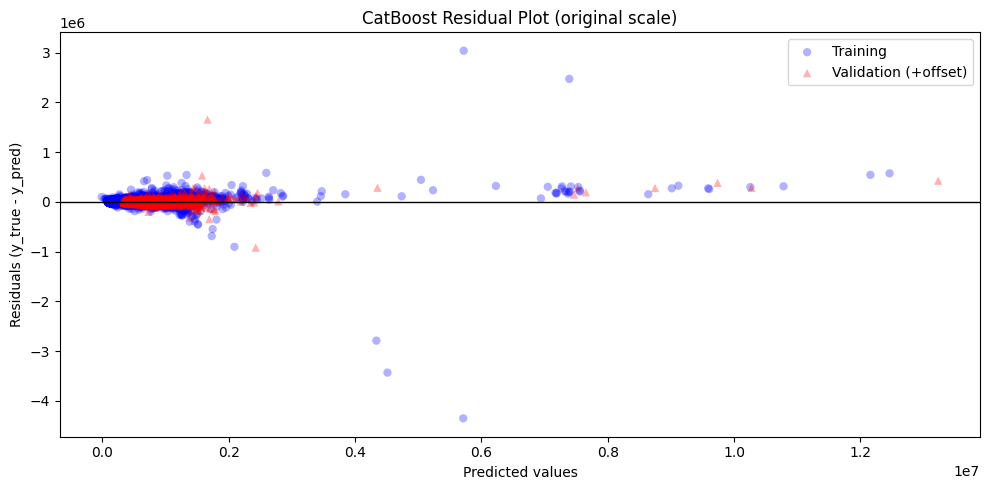

In [17]:

# 1. Dự đoán
train_preds_s = model.predict(X_train_scaled)
val_preds_s   = model.predict(X_val_scaled)

# 2. Inverse scale về thang đo gốc
train_preds = scaler_y.inverse_transform(train_preds_s.reshape(-1, 1)).ravel()
val_preds   = scaler_y.inverse_transform(val_preds_s.reshape(-1, 1)).ravel()
y_train_org = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).ravel()
y_val_org   = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).ravel()

# 3. Hàm vẽ residual plot (có offset để không đè nhau)
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None,
                  title="Residual Plot", figsize=(10, 5), offset_ratio=0.01, alpha=0.3):

    plt.figure(figsize=figsize)

    # Tính residuals
    residuals_train = train_labels - train_preds

    if test_labels is not None and test_preds is not None:
        residuals_test = test_labels - test_preds
        # Tính offset dọc theo trục X (predicted)
        x_min = min(np.min(train_preds), np.min(test_preds))
        x_max = max(np.max(train_preds), np.max(test_preds))
        offset = (x_max - x_min) * offset_ratio
        test_preds_offset = test_preds + offset  # Dời validation sang phải
    else:
        offset = 0
        test_preds_offset = None

    # Vẽ training
    plt.scatter(train_preds, residuals_train,
                c='blue', alpha=alpha, marker='o', edgecolors='none', label='Training')

    # Vẽ validation
    if test_preds_offset is not None:
        plt.scatter(test_preds_offset, residuals_test,
                    c='red', alpha=alpha, marker='^', edgecolors='none', label='Validation (+offset)')

    plt.axhline(y=0, color='black', lw=1)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals (y_true - y_pred)')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# 4. Gọi hàm vẽ (đảm bảo offset để không đè)
residual_plot(
    y_train_org, train_preds,
    y_val_org, val_preds,
    title="CatBoost Residual Plot (original scale)",
    offset_ratio=0.02   # Tăng nếu vẫn đè
)